# Working stuff

1. Set user request - question, sources/stance, period
2. Find similar news
3. Ask openai with context from similar news (from 2)

In [ ]:
import pandas as pd 
import numpy as np
import openai

In [ ]:
df = pd.read_csv('../TG news channels/filtered/df_war_ukr_filtered.csv')

In [ ]:
df.columns

In [ ]:
# model = "paraphrase-multilingual-mpnet-base-v2" -> 768 dimensions
model = 'all-MiniLM-L6-v2'

#### convert ada embeds to np array

In [ ]:
# convert df['ada_embedding'] to numpy array
import ast
from tqdm import tqdm

tqdm.pandas()

df['emb'] = df['ada_embedding'].progress_apply(lambda x: np.array(ast.literal_eval(x)))

In [ ]:
# df[['ada_embedding', 'emb']].head()
type(df['ada_embedding'][0]), type(df['emb'][0])

In [ ]:
df.info(memory_usage='deep')

In [ ]:
df.to_pickle('../TG news channels/filtered/df_war_ukr_filtered_ada_emb.pkl')

In [ ]:
df.info(memory_usage='deep')

In [ ]:
df.columns

In [ ]:
df['ada_embedding'].info(memory_usage='deep')

In [ ]:
# remove ada_embedding (the column is too big and useless as stored as string)
df.drop(columns=['ada_embedding'], inplace=True)
df.to_pickle('../TG news channels/filtered/df_war_ukr_filtered_ada_emb.pkl')

In [17]:
data_path = '/Users/alexbadin/Library/CloudStorage/GoogleDrive-alex.badin@gmail.com/My Drive/Colab Notebooks/Narratives/TG news channels/'
df_sources_types = pd.read_csv(data_path+'/channels.csv', sep=';')

In [18]:
# new variable as per the list above
df_sources_types['stance'] = df_sources_types['content_type']
df_sources_types.loc[df_sources_types['media_type'] == 'tv', 'stance'] = 'tv'
# rename 'propaganda'
df_sources_types['stance'] = df_sources_types['stance'].replace('propaganda', 'inet propaganda')
df_sources_types.stance.value_counts()

stance
inet propaganda    19
altern              9
moder               8
tv                  6
voenkor             6
Name: count, dtype: int64

In [19]:
# add stance to df
df = df.merge(df_sources_types[['channel_name', 'stance']], on='channel_name', how='left')
df.to_pickle('../TG news channels/filtered/df_war_ukr_filtered_ada_emb.pkl')

In [101]:
# deduplicate texts
df.drop_duplicates(subset=['cleaned_message'], inplace=True)
df.to_pickle('../TG news channels/filtered/df_war_ukr_filtered_ada_emb.pkl')

In [102]:
df.shape

(110823, 17)

# User inputs

In [108]:
# question to ask media
request = "Какова ситуация на фронте в Украине"
dates = ['2022-08-01', '2022-12-31'] # list of min and max dates. If only one date - assumed to be min date.
sources = [] # list of sources. Must be exact match to the source name in the dataset 
stance = ['voenkor'] # list of stances. Must be exact match to the content type in the dataset ['inet propaganda', 'altern', 'tv', 'moder', 'voenkor']

# With openai embeddings

Сейчас эмбединги openai обрезанные. Толкьо поэтому файл небольшой. 

Нужна нормальная веткорная база данных. 

### load data

In [63]:
import pandas as pd 
import numpy as np
import openai

### load pickle df & filter

In [64]:
df = pd.read_pickle('../TG news channels/filtered/df_war_ukr_filtered_ada_emb.pkl')

In [65]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127986 entries, 0 to 127985
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   channel_id       127986 non-null  int64 
 1   channel_name     127986 non-null  object
 2   msg_id           127986 non-null  int64 
 3   message          127986 non-null  object
 4   cleaned_message  127986 non-null  object
 5   date             127986 non-null  object
 6   views            127986 non-null  int64 
 7   number_replies   127986 non-null  int64 
 8   number_forwards  127986 non-null  int64 
 9   contains_media   127986 non-null  bool  
 10  media_type       68624 non-null   object
 11  has_url          127986 non-null  bool  
 12  url              15164 non-null   object
 13  domain           15164 non-null   object
 14  document_type    30323 non-null   object
 15  emb              127986 non-null  object
 16  stance           127986 non-null  object
dtypes: bool(2)

In [109]:
# filter by date, source, stance

df_filtered = df.copy()
if dates:
    if len(dates) == 1:
        df_filtered = df_filtered[df_filtered['date'] >= dates[0]]
    elif len(dates) == 2:
        df_filtered = df_filtered[(df_filtered['date'] >= dates[0]) & (df_filtered['date'] <= dates[1])]
if sources:
    df_filtered = df_filtered[df_filtered['source'].isin(sources)]
if stance:
    df_filtered = df_filtered[df_filtered['stance'].isin(stance)]

print(f"Number of messages in the filtered dataset: {df_filtered.shape[0]}, {df_filtered.shape[0]/df.shape[0]*100:.2f}% of the full dataset")

Number of messages in the filtered dataset: 2927, 2.64% of the full dataset


## find top relevant news

In [79]:
api_key = open('API_key.txt', 'r').readline().strip()
openai.api_key = api_key

In [80]:
# embed request
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [81]:
# OPTION 1: find top 10 news closest to request (cosine similarity)

# optional parameter request_emb
def get_top_openai(df, request=None, request_emb=None, model="text-embedding-ada-002", top_n=100):
    if request_emb is None and request is None:
        print('Error: no request')
        return
    if request_emb is None:
        request_emb = get_embedding(request)
    df['cos_sim'] = df['emb'].apply(lambda x: np.dot(x, request_emb)/(np.linalg.norm(x)*np.linalg.norm(request_emb)))
    return df.sort_values(by='cos_sim', ascending=False).head(top_n)

In [110]:
# get embedding for the request & find relevant news
request_ada = get_embedding(request)
top_sim_news = get_top_openai(df_filtered, request_emb=request_ada, top_n = 1000)
top_sim_news.shape

(1000, 18)

<Axes: >

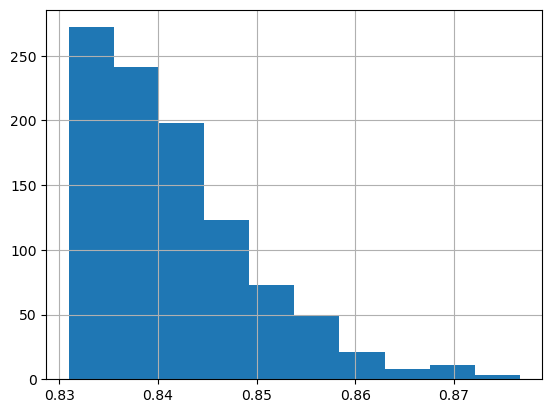

In [111]:
top_sim_news.cos_sim.hist(bins=10)

In [126]:
top_sim_news.reset_index(drop=True, inplace=True)

In [134]:
auc_tot, auc_top, top_sim_news[:10].cos_sim.sum(), top_sim_news.cos_sim.sum()

(10.695854425424503, 0.02388086909354048, 8.716978358044283, 841.6787925123318)

In [127]:
# calculate area under curve for top_sim_news.cos_sim and find optimal threshold (area > 0.5)
from sklearn.metrics import auc
auc_tot = auc(top_sim_news.cos_sim, top_sim_news.index)
# calculate area under curve for top news
top_n = 10
auc_top = auc(top_sim_news.cos_sim[:top_n], top_sim_news.index[:top_n])
print(f"Share of similarity of Top{top_n} news out of total {len(top_sim_news)} = {auc_top / auc_tot}")

Share of similarity of Top10 news out of total 1000 = 0.0022327219634529273


In [113]:
news4request = '\n'.join(top_sim_news[:top_n].cleaned_message.tolist())
len(news4request)

4045

In [115]:
# print with line breaks
print(news4request)

Короткие видео с участка фронта в районе Кременной, полоса обороны 144 мсд. Горящий танк и бмп ВСУ, обстрел украинского опорника в лесополосе. Будни войны.
Чем хуевей дела на фронте (Бахмут) и с критической инфраструктурой, тем сильнее предлагают украинцам жрать информационное говно. Хочу отметить, что взял я это из чата одного крупного горда Украины и там совсем не радуются таким заявлениям, сравнивают с Арестовичем.
❗Несколько тысяч человек арестованы в прифронтовых областях Украины По данным "Страны V", украинские силовики проводят активные репрессии в отношении собственных граждан. В основном речь идет о случайных жертвах доносов. "Всего арестовано несколько тысяч человек. Главным образом это Харьковская, Херсонская, Николаевская и Одесская области", — рассказал источник канала. По его словам, украинские спецслужбы ищут "российских агентов" и не планируют останавливаться на достигнутом. При этом экономическая и гуманитарная ситуация в прифронтовых регионах ухудшается с каждым днем.

### try vector DB?

In [ ]:
# use faiss to find top 10 news closest to request (cosine similarity)
import faiss
def get_top_faiss(df, request_emb, top_n=10):
    df['emb'] = df['emb'].apply(lambda x: np.array(x))
    emb = np.array(df['emb'].tolist())
    emb = np.vstack([request_emb, emb])
    emb = emb.astype('float32')
    index = faiss.IndexFlatIP(768)
    index.add(emb)
    D, I = index.search(emb, top_n)
    return df.iloc[I[0][1:]]

In [ ]:
# OPTION 2
# find top 1000 news closest to request, but with different narratives
# cluster anaysis with representative news from each cluster



# check length (for context window)


## Ask OpenAI

In [118]:
# check length (for context window)
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")
# pricing for GPT3.5 4K
price_1K = 0.0015
def num_tokens_from_string(string: str, encoding_name: str, price_1K = 0.0015) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    if num_tokens > 4096:
        print(f"Warning: num_tokens = {num_tokens} > 4096")
    return f"N of tokens - {num_tokens} vs  Max 4,096 tokens ; Cost - ${round(num_tokens/1000*price_1K, 3)}"

In [119]:
num_tokens_from_string(news4request, "cl100k_base", price_1K = price_1K)

'N of tokens - 2045 vs  Max 4,096 tokens ; Cost - $0.003'

In [120]:
print(request)
num_tokens_from_string(request, "cl100k_base", price_1K = price_1K)

Какова ситуация на фронте в Украине


'N of tokens - 19 vs  Max 4,096 tokens ; Cost - $0.0'

In [93]:
# simple function - suceptible to openai disconnection

def ask_openai(request, news4request):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {
            "role": "system",
            "content": "You are given few short texts in Russian. Based on this texts answer the following question:\n{request}"
            },
            {
            "role": "user",
            "content": news4request
            }
        ],
        temperature=1,
        max_tokens=512,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
        )
    return response

In [121]:
# code for openai connection problems

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return openai.ChatCompletion.create(**kwargs)

def ask_openai(request, news4request, model_name="gpt-3.5-turbo"):
    response = completion_with_backoff(
                model = model_name,
                messages=[
                    {
                    "role": "system",
                    "content": "You are given few short texts in Russian. Based on this texts answer the following question:\n{request}. \nОтвечай на русском."
                    },
                    {
                    "role": "user",
                    "content": news4request
                    }
                ],
                temperature=1,
                max_tokens=512,
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0
    )
    return response

In [122]:
reply = ask_openai(request, news4request)

In [123]:
import textwrap

reply_text = reply.choices[0]['message']['content']
reply_cost = reply.usage.total_tokens / 1000 * price_1K
print(f"Cost - ${round(reply_cost, 3)}")
print(f"Request: {request}; \nFilters: dates: {dates}; sources: {sources}; stance: {stance}")
print()
# print wrapped text
print('\n'.join(textwrap.wrap(reply_text, 100)))

Cost - $0.004
Request: Какова ситуация на фронте в Украине; 
Filters: dates: ['2022-08-01', '2022-12-31']; sources: []; stance: ['voenkor']

На основании предоставленных текстов можно сделать вывод о том, что на фронте в Украине продолжаются
боевые действия. Видеозаписи и сводки сообщают о горящих танках и БМП ВСУ, обстреле опорников и
активной деятельности российских и украинских сил. Также упоминается ухудшение экономической и
гуманитарной ситуации в прифронтовых регионах. Кроме того, тексты содержат информацию о числе
арестованных людей и проводимых репрессиях в отношении граждан Украины. В некоторых текстах также
упоминаются попытки противников атаковать позиции сил РФ, но сопротивление оказывается успешным.


In [135]:
# add reply & inputs to csv-file
import csv

# if file does not exist write header
with open('openai_chatbot.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['request', 'dates', 'sources', 'stance', 'reply_text', 'reply_cost'])

with open('openai_chatbot.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([request, dates, sources, stance, reply_text, reply_cost])